**PROBLEM STATEMENT**

In this project, we had to identify major customer segments on a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

**Data Description**

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.

UnitPrice: Unit price. Numeric, Product price per unit in sterling.

CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal, the name of the country where each customer resides.

Importing Libraries

In [ ]:
#Load all the required packages
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

Reading Dataset 

In [ ]:
df= pd.read_excel("/content/drive/MyDrive/Colab Notebooks/unsupervised - online retail customer segmentation/dataset.xlsx")

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.shape

(541909, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Since later we are going to groupby by customerid and find clusters , all the rows where customerid is null are useless so we drop them.
THere are few rows where description is null , so we even drop them.

In [ ]:
df.dropna(inplace=True)

We even drop all the rows of cancled orders

In [ ]:
cancelled_orders = df[df['InvoiceNo'].astype(str).str.contains('C')]
print("There were", len(cancelled_orders), "cancelled orders.")

There were 8905 cancelled orders.


In [ ]:
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df=df[~df['InvoiceNo'].str.contains('C')]

In [ ]:
df.shape

(397924, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


**ADDING NEW COLUMNS**

In [ ]:
df['TotalAmount']=df['Quantity']*df['UnitPrice']

In [ ]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format="%Y-%m-%d %H:%M:%S")

df['Day']=df['InvoiceDate'].dt.day_name()

In [ ]:
df["year"] = df["InvoiceDate"].apply(lambda x: x.year)
df["month"] = df["InvoiceDate"].apply(lambda x: x.month)
df["hour"] = df["InvoiceDate"].apply(lambda x: x.hour)


In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,Day,year,month,hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,Wednesday,2010,12,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,2010,12,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,Wednesday,2010,12,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,2010,12,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,2010,12,8


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID,TotalAmount,year,month_num,day_num,hour,minute
count,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171,22.394749,2010.934259,7.612537,15.042181,12.728247,30.408013
std,180.420210,22.096788,1713.169877,309.055588,0.247829,3.416527,8.653771,2.273535,17.078163
min,1.000000,0.000000,12346.000000,0.000000,2010.000000,1.000000,1.000000,6.000000,0.000000
25%,2.000000,1.250000,13969.000000,4.680000,2011.000000,5.000000,7.000000,11.000000,16.000000
50%,6.000000,1.950000,15159.000000,11.800000,2011.000000,8.000000,15.000000,13.000000,31.000000
75%,12.000000,3.750000,16795.000000,19.800000,2011.000000,11.000000,22.000000,14.000000,45.000000
max,80995.000000,8142.750000,18287.000000,168469.600000,2011.000000,12.000000,31.000000,20.000000,59.000000


In [ ]:
df.describe(include=['object','bool'])

,InvoiceNo,StockCode,Description,Country,Day
count,397924,397924,397924,397924,397924
unique,18536,3665,3877,37,6
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,Thursday
freq,542,2035,2028,354345,80052


In [ ]:
print("Number of transactions: ", df['InvoiceNo'].nunique())
print("Number of products bought: ", df['StockCode'].nunique())
print("Number of customers:", df['CustomerID'].nunique())
print('Number of countries: ', df['Country'].nunique())

Number of transactions:  18536
Number of products bought:  3665
Number of customers: 4339
Number of countries:  37


The count of unique stock unit ids and their descriptions should have matched but they do not. This implies some stock units might have more than one descriptions.

In [ ]:
#Find number of unique items in stock
print(f"Number of unique item stock codes: {len(df.StockCode.unique())}")
print(f"Number of unique item descriptions: {len(df.Description.unique())}")

Number of unique item stock codes: 3665
Number of unique item descriptions: 3877


**EXPLORATORY DATA ANALYSIS**

**Analysis based on Stockcode**

In [ ]:
df['StockCode'].value_counts().head()

85123A    2035
22423     1724
85099B    1618
84879     1408
47566     1397
Name: StockCode, dtype: int64

Text(0.5, 1.0, 'Top 5 stockcode')

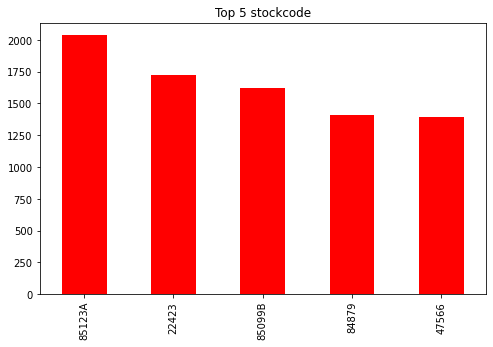

In [ ]:
df['StockCode'].value_counts().head().plot.bar(figsize=(8,5) ,color='r')
plt.title('Top 5 stockcode')





**Analysis based on country**

There are 37 countries.
But 88% of rows are from UK

In [ ]:
df['Country'].nunique()

37

In [ ]:
df['Country'].value_counts().head()

United Kingdom    354345
Germany             9042
France              8342
EIRE                7238
Spain               2485
Name: Country, dtype: int64

Text(0.5, 1.0, 'Top 5 countries')

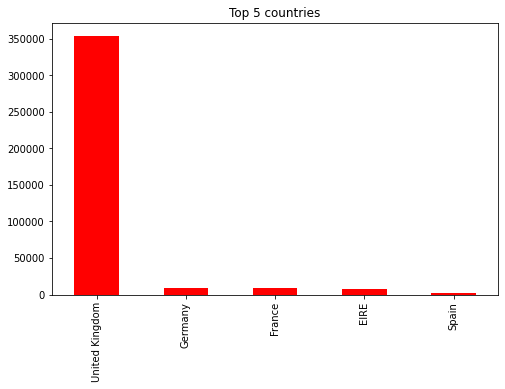

In [ ]:
df['Country'].value_counts().head().plot.bar(figsize=(8,5) ,color='r')
plt.title('Top 5 countries')


**Analysis based on Quantity, Unitprice and Totalamount**

In [ ]:
print(df.Quantity.describe())
print("  ")
print(df.UnitPrice.describe())
print("  ")
print(df.TotalAmount.describe())

count    397924.000000
mean         13.021823
std         180.420210
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64
  
count    397924.000000
mean          3.116174
std          22.096788
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64
  
count    397924.000000
mean         22.394749
std         309.055588
min           0.000000
25%           4.680000
50%          11.800000
75%          19.800000
max      168469.600000
Name: TotalAmount, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

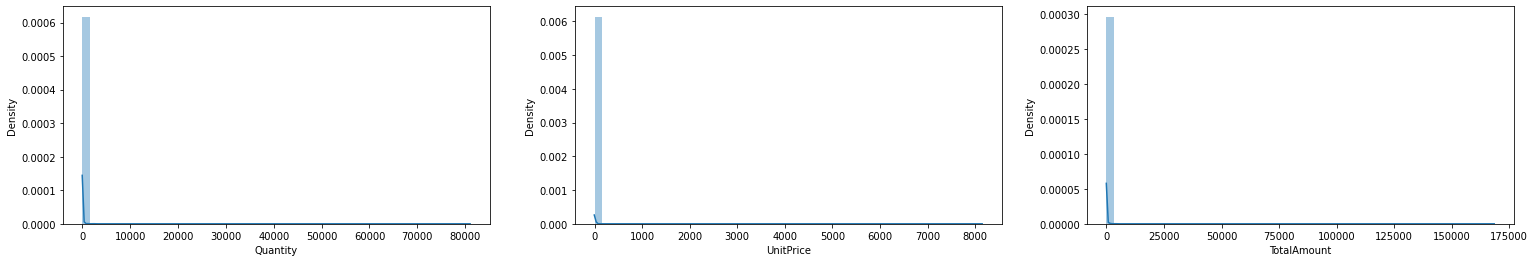

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(26, 4))

sns.distplot(df['Quantity'], ax=axes[0]);
sns.distplot(df['UnitPrice'], ax=axes[1]);
sns.distplot(df['TotalAmount'], ax=axes[2]);


**Analysis based on Day**

No sales were done on saturday, maybe saturday is holiday.

On Thrusday most no of sales were done, ie 20% more than avg sales.

On friday leaset no of sales were done.

In [ ]:
df['Day'].value_counts()

Thursday     80052
Wednesday    68888
Tuesday      66476
Monday       64899
Sunday       62775
Friday       54834
Name: Day, dtype: int64

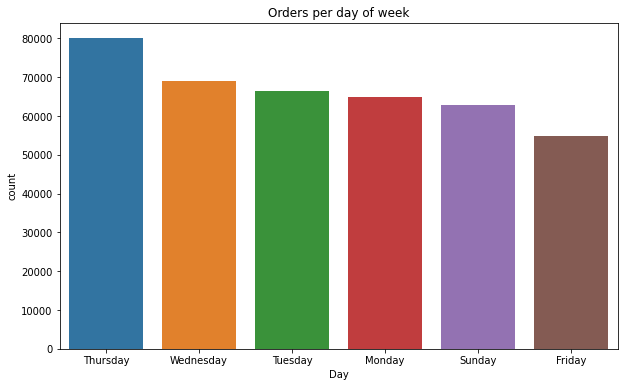

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Orders per day of week')
sns.countplot(x='Day' , data=df ,order = df['Day'].value_counts().index)

**Analysis based on month**

Last 4 months of year witness most no of orders.

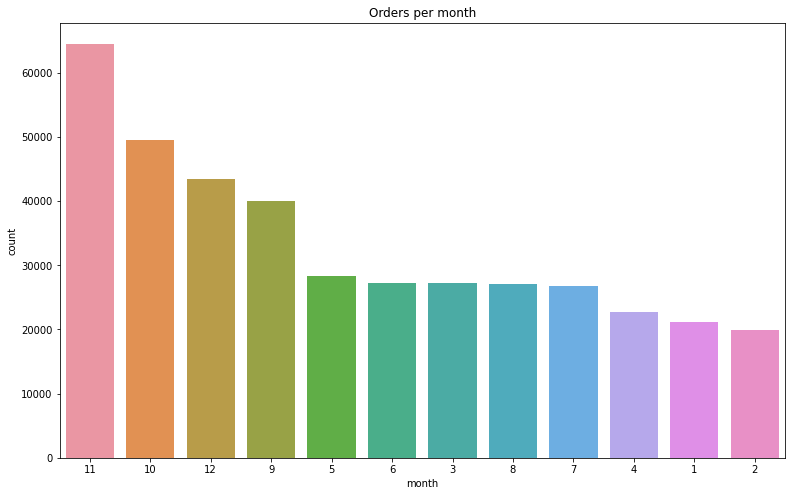

In [ ]:
plt.figure(figsize=(13,8))
plt.title('Orders per month')
sns.countplot(x='month' , data=df ,order = df['month'].value_counts().index )


**Analysis based on Hour**

The afternoon hours , ie from 11-3 witness most no of orders.

No orders are taken from 8pm till 6am

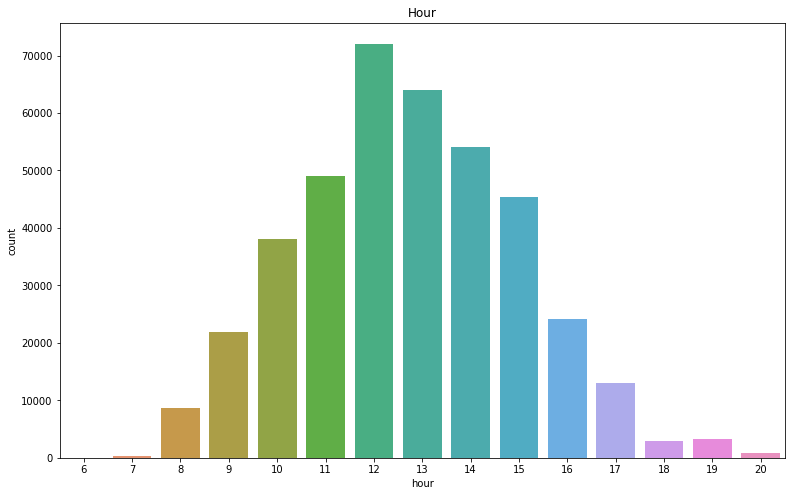

In [ ]:
plt.figure(figsize=(13,8))
plt.title('Hour')
sns.countplot(x='hour' , data=df )

**Analysis based on year**

Most of the orders are in 2011 year.

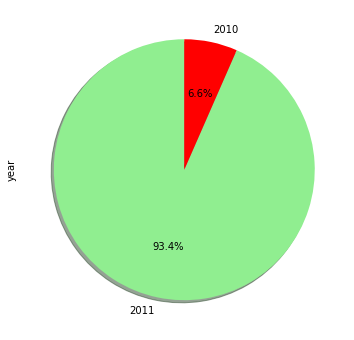

In [ ]:
df['year'].value_counts().plot(kind='pie',
                              figsize=(15,6),
                               autopct="%1.1f%%",
                               startangle=90,
                               shadow=True,
                               labels=['2011','2010'],
                               colors=['lightgreen','red'],
                               explode=[0,0]
                              )

Number of Items per Order     

Number of Items per Customer

In [ ]:
a = pd.DataFrame(df.groupby('InvoiceNo')['StockCode'].nunique())
a.columns = ['Number of Items per Order']
a.head()

,Number of Items per Order
InvoiceNo,
536365,7
536366,2
536367,12
536368,4
536369,1


In [ ]:
b = pd.DataFrame(df.groupby('CustomerID')['StockCode'].nunique())
b.columns = ['Number of Items per Customer']
b.head()

,Number of Items per Customer
CustomerID,
12346.0,1
12347.0,103
12348.0,22
12349.0,73
12350.0,17


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


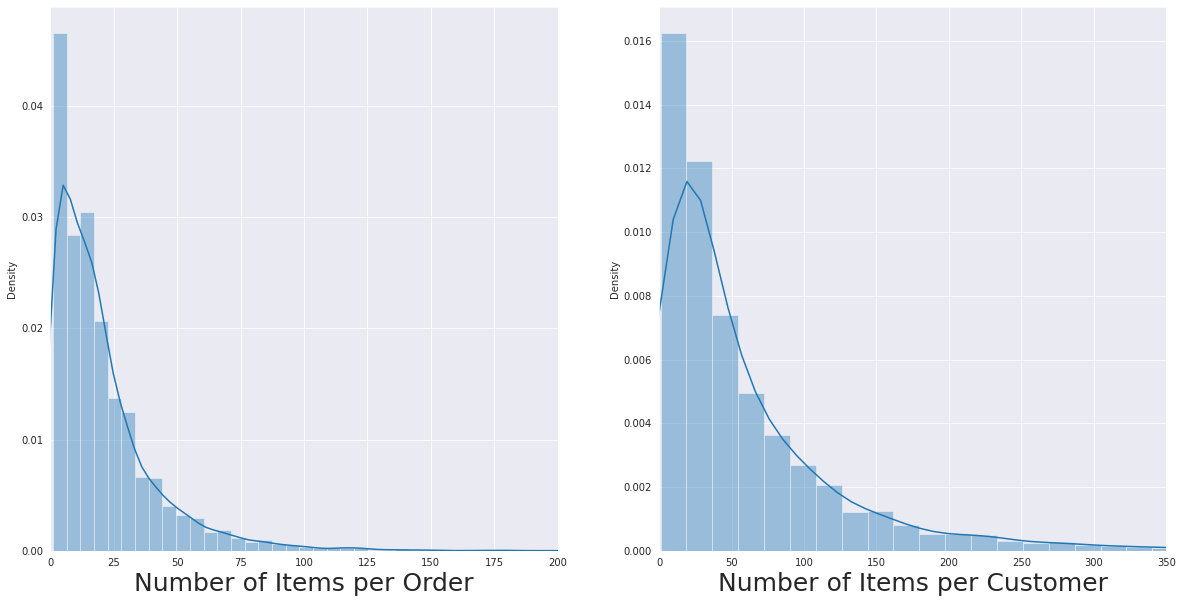

In [ ]:
#Visualize the distribution of both
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20, 10)
plt1 = sns.distplot(a['Number of Items per Order'], ax=ax[0], bins=100)
plt1.set_xlim(0,200)
plt1.set_xlabel(xlabel='Number of Items per Order',fontsize=25)
plt2 = sns.distplot(b['Number of Items per Customer'], ax=ax[1], bins=100)
plt2.set_xlim(0,350)
plt2.set_xlabel(xlabel='Number of Items per Customer',fontsize=25)
plt.show()

**Create the RFM model (Recency, Frequency,Monetary value)**

Recency, frequency, monetary value is a marketing analysis tool used to identify a company's or an organization's best customers by using certain measures.The first step in building an RFM model is to assign Recency, Frequency and Monetary values to each customer.

**1. Recency:**

We fix a reference date for finding the recent transactions. The reference date would be a day after the most recent transaction date in the dataset. Then we calculate the days difference between the most recent transaction carried out by the customer and this reference date


In [ ]:
referenceDate = df['InvoiceDate'].max()
referenceDate += datetime.timedelta(days = 1)

df['Recency'] = (referenceDate - df['InvoiceDate']).astype('timedelta64[D]')
new_df = df.groupby("CustomerID")['Recency'].min().reset_index()
new_df.head()

,CustomerID,Recency
0,12346.0,326.0
1,12347.0,2.0
2,12348.0,75.0
3,12349.0,19.0
4,12350.0,310.0


**2. Frequency:**

Calculate the frequency of transactions for each customer


In [ ]:
dfCustomerFrequency = df[['CustomerID', 'TotalAmount']].groupby('CustomerID').count().reset_index()
dfCustomerFrequency.rename(columns={'TotalAmount': 'Frequency'}, inplace= True)
new_df = new_df.merge(dfCustomerFrequency, how="outer")
new_df.head()

,CustomerID,Recency,Frequency
0,12346.0,326.0,1
1,12347.0,2.0,182
2,12348.0,75.0,31
3,12349.0,19.0,73
4,12350.0,310.0,17


**Monetary Value**

What is total money a customer pays in all the orders he has placed

In [ ]:

dfCustomerMV = df[['CustomerID', 'TotalAmount']].groupby('CustomerID').sum().reset_index()
dfCustomerMV.rename(columns={'TotalAmount': 'MonetaryValue'}, inplace= True)
new_df = new_df.merge(dfCustomerMV, how="outer")
#add a small number to monetary value to avoid problems with zeros as we transform to log scale
new_df["MonetaryValue"] = new_df["MonetaryValue"] + 0.001
new_df.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,326.0,1,77183.601
1,12347.0,2.0,182,4310.001
2,12348.0,75.0,31,1797.241
3,12349.0,19.0,73,1757.551
4,12350.0,310.0,17,334.401


**log transformation and feature scaling**


Since, all the features like Recency, Frequency and Monetary value are within varying ranges of values, we need to standardize them. In addition, the feature like "Monetary value" can take a very large range of values. So, to standardize all the inputs features, we apply log transform, so that the input to our clustering algorithm is a set of well scaled and transformed features.

In [ ]:
#Applying log transformations
new_df['log_Recency'] = new_df["Recency"].apply(math.log)
new_df['log_Frequency'] = new_df["Frequency"].apply(math.log)
new_df['log_MonetaryValue'] = new_df["MonetaryValue"].apply(math.log)

#Preparing matrix for standard scaling transformation
X = new_df[["log_Recency", "log_Frequency", "log_MonetaryValue"]]
#Standardize the features (mean 0 and std. dev 1)
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [ ]:
X_scaled

array([[ 1.41013769, -2.77292853,  3.6536713 ],
       [-2.14641051,  1.14932524,  1.39453161],
       [ 0.38416966, -0.18473638,  0.70965601],
       ...,
       [-1.1784748 , -0.90005729, -1.10058325],
       [-1.66244265,  2.22261852,  0.82964555],
       [-0.00424065,  0.42915738,  0.7269086 ]])

In [ ]:
new_df.head()

,CustomerID,Recency,Frequency,MonetaryValue,log_Recency,log_Frequency,log_MonetaryValue
0,12346.0,326.0,1,77183.601,5.786897,0.000000,11.253942
1,12347.0,2.0,182,4310.001,0.693147,5.204007,8.368693
2,12348.0,75.0,31,1797.241,4.317488,3.433987,7.494008
3,12349.0,19.0,73,1757.551,2.944439,4.290459,7.471677
4,12350.0,310.0,17,334.401,5.736572,2.833213,5.812341


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


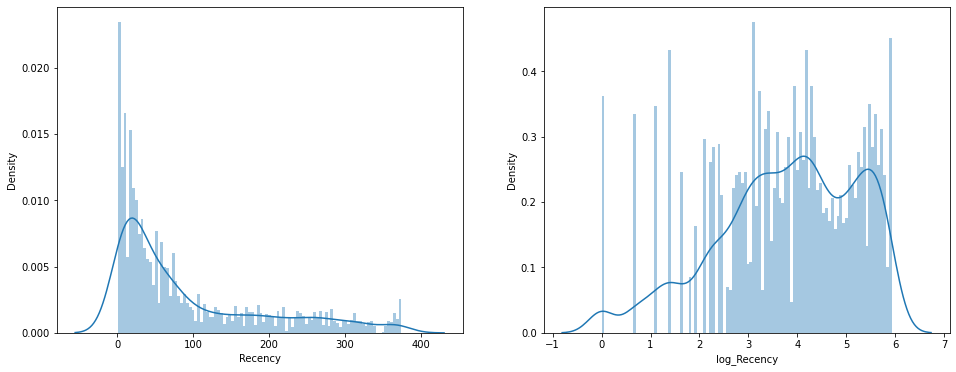

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.distplot(new_df['Recency'] , bins=100 , ax=axes[0])
sns.distplot(new_df['log_Recency'] ,bins=100 ,  ax=axes[1])


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


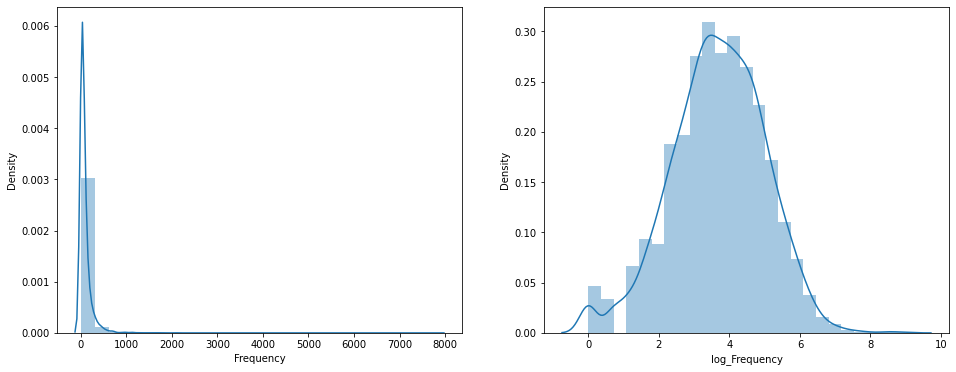

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.distplot(new_df['Frequency'] , bins=25 , ax=axes[0])
sns.distplot(new_df['log_Frequency'] ,bins=25 ,  ax=axes[1])


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


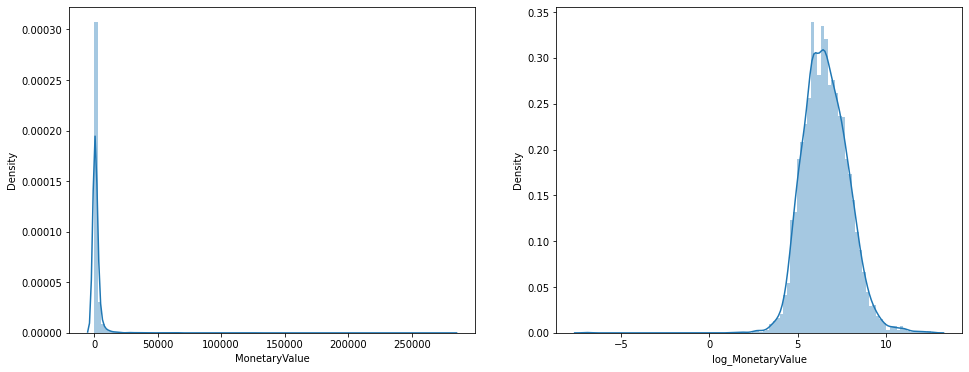

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.distplot(new_df['MonetaryValue'] , bins=100 , ax=axes[0])
sns.distplot(new_df['log_MonetaryValue'] ,bins=100 ,  ax=axes[1])


Visualizing the relationship between R, F and M

Text(0.5, 0, 'MonetaryValue')

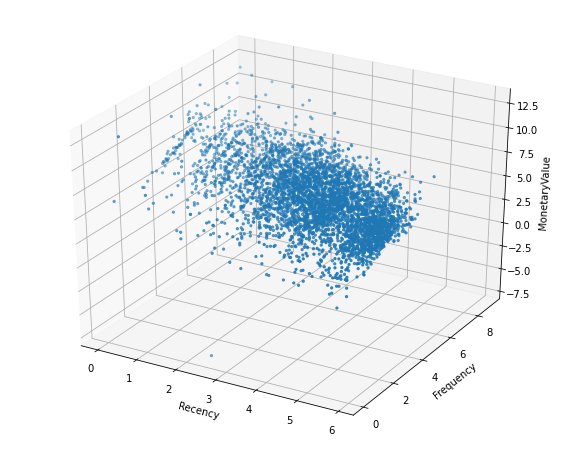

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

xs =new_df.log_Recency
ys = new_df.log_Frequency
zs = new_df.log_MonetaryValue
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('MonetaryValue')

In [ ]:
log_new_df = pd.DataFrame({'log_Recency': new_df['log_Recency']      , 'log_Frequency': new_df['log_Frequency']  , 'log_MonetaryValue': new_df['log_MonetaryValue']})

In [ ]:
log_new_df.head()

,log_Recency,log_Frequency,log_MonetaryValue
0,5.786897,0.000000,11.253942
1,0.693147,5.204007,8.368693
2,4.317488,3.433987,7.494008
3,2.944439,4.290459,7.471677
4,5.736572,2.833213,5.812341


In [ ]:
from pandas.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c98afe310>,
      dtype=object)

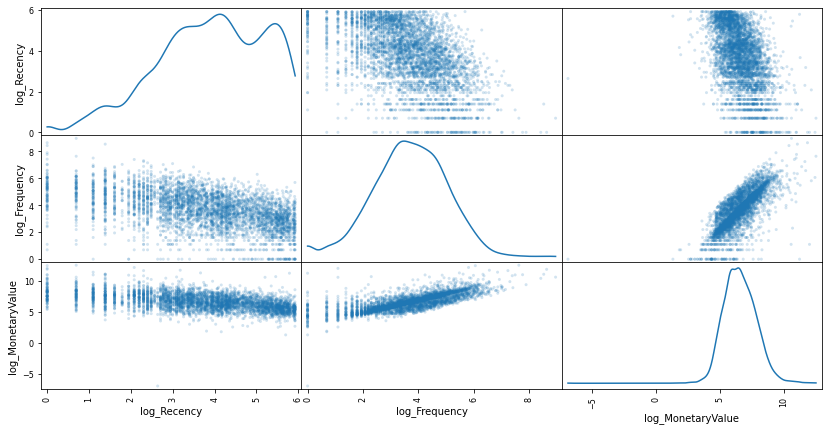

In [ ]:
scatter_matrix(log_new_df, alpha = 0.2, figsize = (14,7), diagonal = 'kde')

In [ ]:
log_new_df.corr()

,log_Recency,log_Frequency,log_MonetaryValue
log_Recency,1.000000,-0.484678,-0.475831
log_Frequency,-0.484678,1.000000,0.753162
log_MonetaryValue,-0.475831,0.753162,1.000000


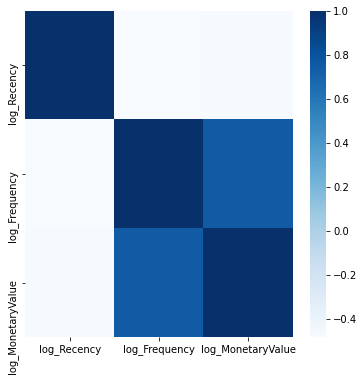

In [ ]:
fig = plt.figure(figsize=(6, 6))
sns.heatmap(log_new_df.corr(),cmap="Blues")

**K-Means Implementation**

Clustering is an unsupervised classification techinque to understand the groups of classes in the data. We use the K-means clustering algorithm to determine the ideal segments of customers.

Here in k-means, we have to set k to the number of clusters we want, but figuring out how many clusters is not obvious from the beginning. We will try different cluster numbers and check their silhouette coefficient. 

Silhouette score is used to evaluate the quality of clusters created using clustering algorithms such as K-Means in terms of how well samples are clustered with other samples that are similar to each other. The Silhouette score is calculated for each sample of different clusters. The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar).

In [ ]:
matrix = log_new_df.to_numpy() 
for n_clusters in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.39412108102420657
For n_clusters = 3 The average silhouette_score is : 0.3019316867735708
For n_clusters = 4 The average silhouette_score is : 0.3051109197771432
For n_clusters = 5 The average silhouette_score is : 0.28207678314579454
For n_clusters = 6 The average silhouette_score is : 0.28078281749121237
For n_clusters = 7 The average silhouette_score is : 0.27017672382549857
For n_clusters = 8 The average silhouette_score is : 0.2684940128150619
For n_clusters = 9 The average silhouette_score is : 0.26733586282125127


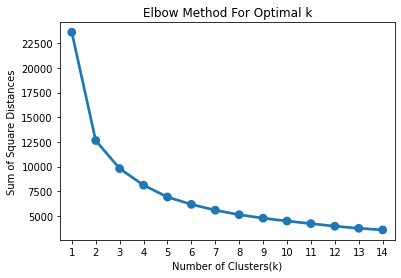

In [ ]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(log_new_df)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

**When cluster = 2**

In [ ]:
n_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters_customers = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters_customers)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.394


Visualize the Clusters

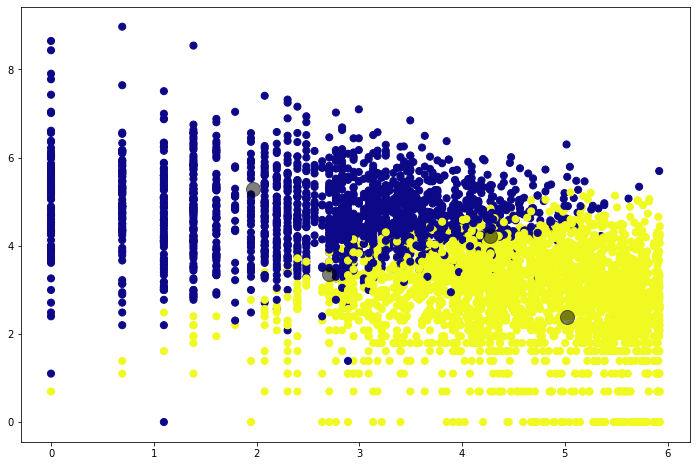

In [ ]:
#create a scatter plot
plt.figure(figsize=(12,8))
plt.scatter(matrix[:, 0], matrix[:, 1], c=clusters_customers, s=50, cmap='plasma')
#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)


In [ ]:

#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 2, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(log_new_df)

#Find the clusters for the observation given in the dataset
new_df['Cluster'] = KMean_clust.labels_
new_df.head(10)

,CustomerID,Recency,Frequency,MonetaryValue,log_Recency,log_Frequency,log_MonetaryValue,Cluster
0,12346.0,326.0,1,77183.601,5.786897,0.000000,11.253942,1
1,12347.0,2.0,182,4310.001,0.693147,5.204007,8.368693,0
2,12348.0,75.0,31,1797.241,4.317488,3.433987,7.494008,1
3,12349.0,19.0,73,1757.551,2.944439,4.290459,7.471677,0
4,12350.0,310.0,17,334.401,5.736572,2.833213,5.812341,1
5,12352.0,36.0,85,2506.041,3.583519,4.442651,7.826459,0
6,12353.0,204.0,4,89.001,5.318120,1.386294,4.488648,1
7,12354.0,232.0,58,1079.401,5.446737,4.060443,6.984162,1
8,12355.0,214.0,13,459.401,5.365976,2.564949,6.129923,1
9,12356.0,23.0,59,2811.431,3.135494,4.077537,7.941449,0


**When cluster = 4**

In [ ]:
n_clusters = 4
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters_customers_4 = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters_customers)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.394


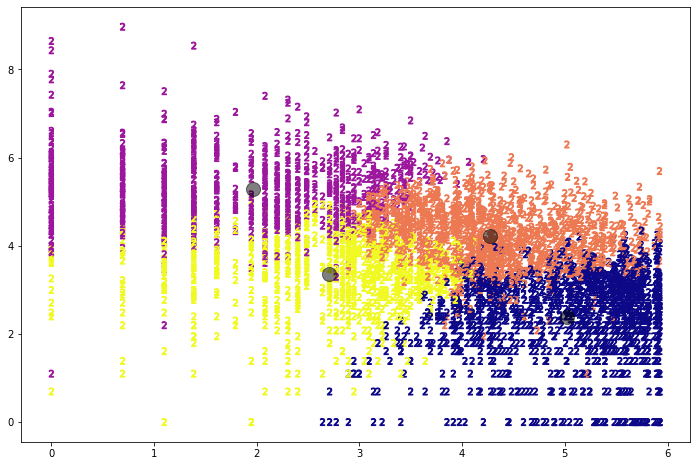

In [ ]:
#create a scatter plot
plt.figure(figsize=(12,8))

plt.scatter(matrix[:, 0], matrix[:, 1], c=clusters_customers_4, s=50, cmap='plasma', marker='$%d$' % 2 , alpha=1)
#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)


In [ ]:

#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 4, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(log_new_df)

#Find the clusters for the observation given in the dataset
new_df['Cluster'] = KMean_clust.labels_
new_df.head(10)

,CustomerID,Recency,Frequency,MonetaryValue,log_Recency,log_Frequency,log_MonetaryValue,Cluster
0,12346.0,326.0,1,77183.601,5.786897,0.000000,11.253942,3
1,12347.0,2.0,182,4310.001,0.693147,5.204007,8.368693,2
2,12348.0,75.0,31,1797.241,4.317488,3.433987,7.494008,3
3,12349.0,19.0,73,1757.551,2.944439,4.290459,7.471677,3
4,12350.0,310.0,17,334.401,5.736572,2.833213,5.812341,1
5,12352.0,36.0,85,2506.041,3.583519,4.442651,7.826459,3
6,12353.0,204.0,4,89.001,5.318120,1.386294,4.488648,1
7,12354.0,232.0,58,1079.401,5.446737,4.060443,6.984162,3
8,12355.0,214.0,13,459.401,5.365976,2.564949,6.129923,1
9,12356.0,23.0,59,2811.431,3.135494,4.077537,7.941449,3
